<a href="https://colab.research.google.com/github/Ranazzi/GANparam/blob/main/ProjetoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
from __future__ import print_function, division

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


In [30]:
!pip install mat73

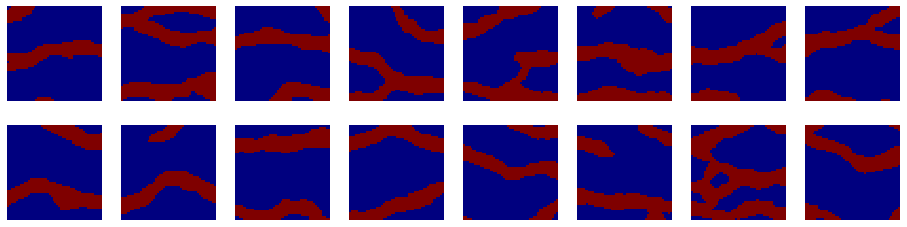

In [31]:
# Load the dataset
import mat73
X_train_raw = mat73.loadmat('gdrive/My Drive/Colab Notebooks/Projeto/C10000.mat')['chan10000']

X_train_raw = np.reshape(X_train_raw, (50, 50, 10000))
X_train_raw = np.einsum('xyn->nxy', X_train_raw)

r, c = 2, 8
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train_raw[cnt,:,:], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()


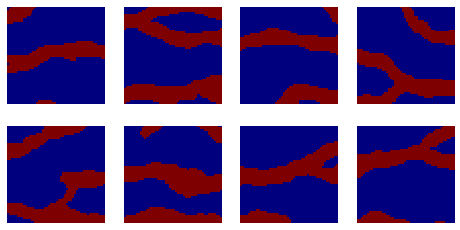

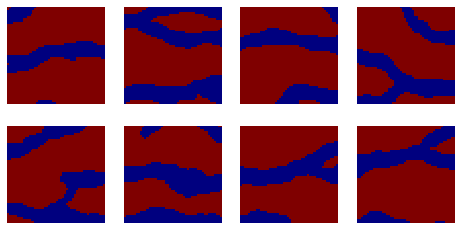

In [32]:
# #decompose into two channels
X_train=np.zeros((X_train_raw.shape[0],X_train_raw.shape[1],X_train_raw.shape[2],2))
for i in range(X_train_raw.shape[0]):
  for j in range(X_train_raw.shape[1]):
    for k in range(X_train_raw.shape[2]):
      if X_train_raw[i,j,k]==1:
        X_train[i,j,k,0]=1
        X_train[i,j,k,1]=-1
      else:
        X_train[i,j,k,1]=1
        X_train[i,j,k,0]=-1

r, c = 2, 4
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train[cnt,:,:,0], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()
r, c = 2, 4
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(X_train[cnt,:,:,1], cmap = cm.jet, aspect = 'equal', interpolation = 'none')
        axs[i,j].axis('off')
        cnt += 1
plt.show()
plt.close()

In [33]:
def build_generator(latent_dim, img_shape):
  model = Sequential()

  model.add(layers.Dense(7*7*128, activation = 'relu', input_dim=latent_dim)) #camada densa
  model.add(layers.Reshape((7, 7, 128))) #reshape

  model.add(layers.UpSampling2D()) #upsampling (aumenta o número de linhas)
  model.add(layers.Conv2D(128, kernel_size=2, strides=1, padding="valid")) #convd2 3x3 com stride de 1

  model.add(layers.UpSampling2D()) #upsampling (aumenta o número de linhas)
  model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding="same")) #convd2 3x3 com stride de 1
  model.add(layers.BatchNormalization(momentum=0.8)) #batch normalization
  model.add(layers.Activation("relu")) #camada de ativação com função relu

  model.add(layers.UpSampling2D())
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding="valid")) #convd2 3x3 com stride de 1
  model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding="same")) #convd2 3x3 com stride de 1
  model.add(layers.BatchNormalization(momentum=0.8)) #batch normalization
  model.add(layers.Activation("relu")) #camada de ativação com função relu

  model.add(layers.Conv2D(2, kernel_size=3, strides=1, padding="same", activation = 'tanh')) #convd2 3x3 com stride de 1 e actv tanh

  # model.summary()
  
  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
  # model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  # model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def sample_images(iter, generator):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, latent_dim))
  gen_imgs = generator.predict(noise)

  #get maximum activation value as facie type
  faciet=np.zeros((gen_imgs.shape[0],gen_imgs.shape[1],gen_imgs.shape[2]))

  for i in range(gen_imgs.shape[0]):
   for j in range(gen_imgs.shape[1]):
    for k in range(gen_imgs.shape[2]):
      if gen_imgs[i,j,k,0] > gen_imgs[i,j,k,1]:
        faciet[i,j,k]=1

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(faciet[cnt,:,:], aspect='equal', cmap = cm.jet, interpolation = 'none',clim = (0, 1))
          axs[i,j].axis('off')
          cnt += 1
  plt.show()
  plt.close()

In [34]:
img_shape = (50, 50, 2)
latent_dim = 500

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 50, 2)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 1)                 400673    
                                                                 
Total params: 400,673
Trainable params: 400,673
Non-trainable params: 0
_________________________________________________________________
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 500)]             0         
                                                                 
 model_7 (Functional)        (None, 50, 50, 2)         3448994   
                                                                 
 model_6 (Functional)        (None, 

In [35]:
#normalization
batch_size=64
# Re-escale de -1 a 1
# X_train = X_train / 127.5 - 1.
# X_train = np.expand_dims(X_train, axis=3)

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

0 [D loss: 0.718991, acc.: 14.84%] [G loss: 0.649982]


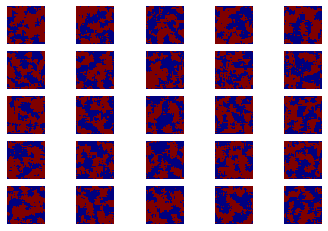

25 [D loss: 0.776551, acc.: 48.44%] [G loss: 0.587614]


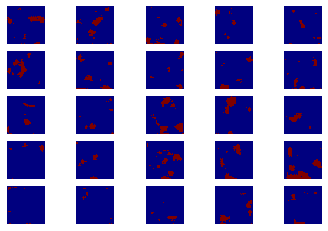

50 [D loss: 0.662411, acc.: 60.16%] [G loss: 0.546487]


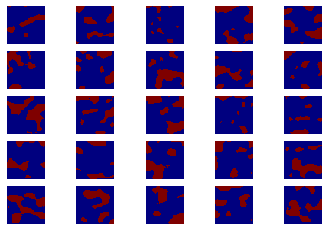

75 [D loss: 0.304570, acc.: 95.31%] [G loss: 0.716266]


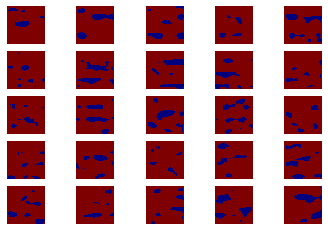

100 [D loss: 0.503953, acc.: 91.41%] [G loss: 0.645437]


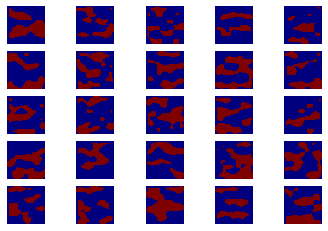

125 [D loss: 0.776551, acc.: 37.50%] [G loss: 0.702957]


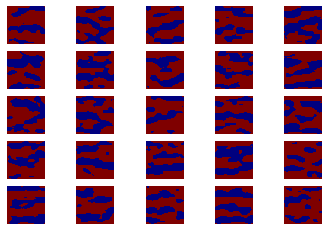

150 [D loss: 1.067558, acc.: 30.47%] [G loss: 0.882909]


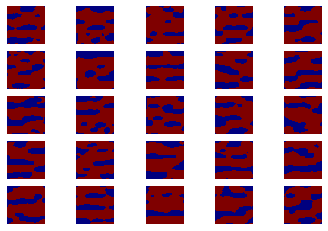

175 [D loss: 0.620041, acc.: 75.00%] [G loss: 0.799192]


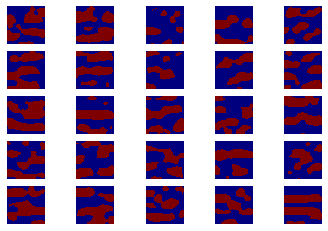

200 [D loss: 0.491887, acc.: 78.12%] [G loss: 0.077654]


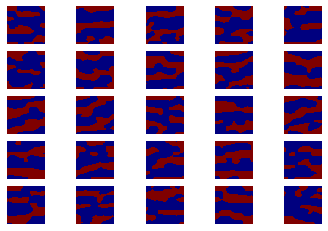

225 [D loss: 0.710809, acc.: 45.31%] [G loss: 0.869366]


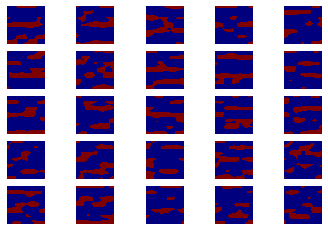

250 [D loss: 0.638179, acc.: 67.97%] [G loss: 0.878863]


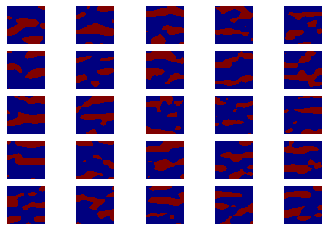

275 [D loss: 0.425302, acc.: 88.28%] [G loss: 0.355966]


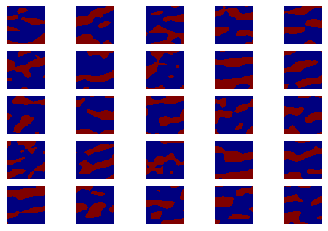

300 [D loss: 0.648166, acc.: 64.84%] [G loss: 1.163418]


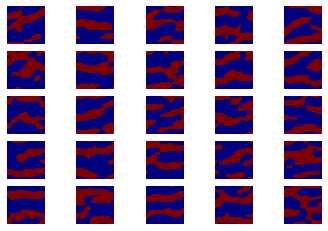

325 [D loss: 0.538376, acc.: 85.94%] [G loss: 1.158343]


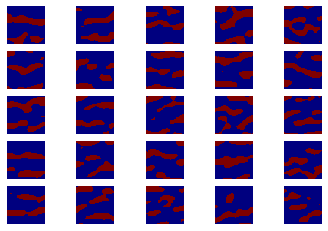

350 [D loss: 0.497127, acc.: 80.47%] [G loss: 1.238312]


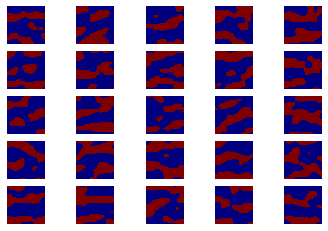

375 [D loss: 0.424692, acc.: 81.25%] [G loss: 0.054656]


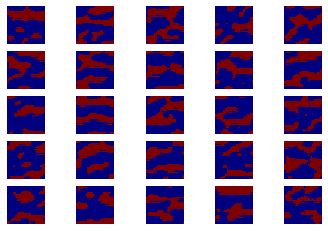

400 [D loss: 0.490096, acc.: 82.03%] [G loss: 1.556665]


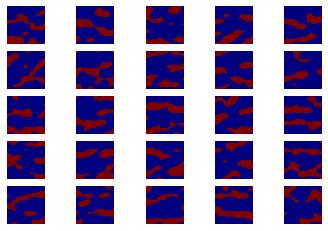

425 [D loss: 0.294119, acc.: 90.62%] [G loss: 1.876546]


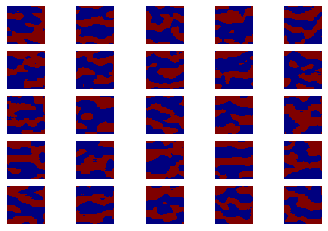

450 [D loss: 0.467969, acc.: 78.12%] [G loss: 1.920286]


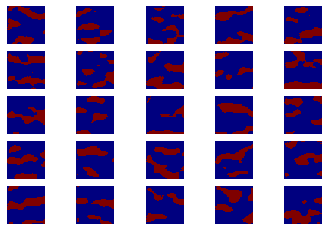

475 [D loss: 0.209528, acc.: 92.97%] [G loss: 0.222956]


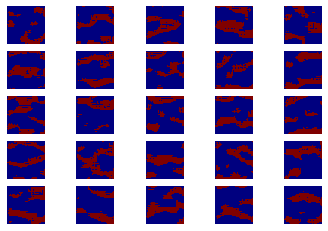

500 [D loss: 0.523635, acc.: 76.56%] [G loss: 1.640781]


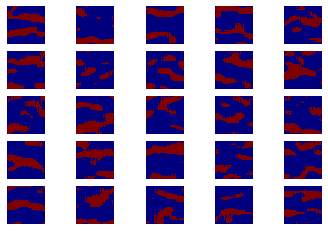

525 [D loss: 0.537470, acc.: 77.34%] [G loss: 3.230557]


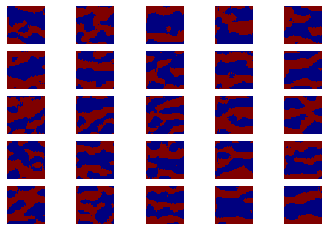

550 [D loss: 0.320248, acc.: 92.97%] [G loss: 2.186904]


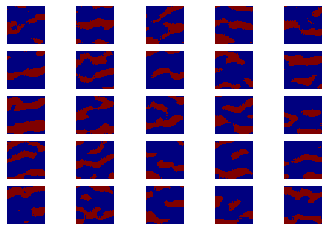

575 [D loss: 0.785310, acc.: 57.81%] [G loss: 3.929526]


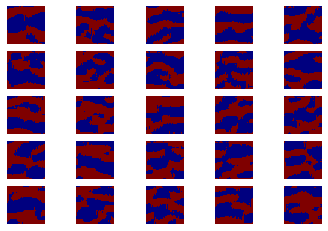

600 [D loss: 0.375148, acc.: 80.47%] [G loss: 3.062737]


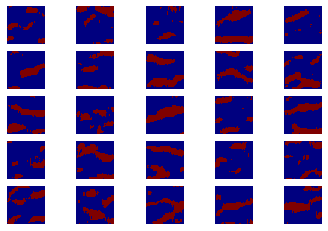

625 [D loss: 0.716269, acc.: 64.84%] [G loss: 8.979937]


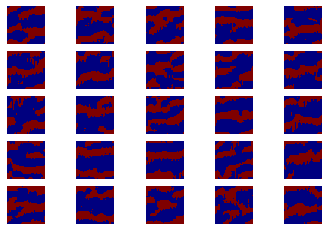

650 [D loss: 0.011939, acc.: 99.22%] [G loss: 5.553336]


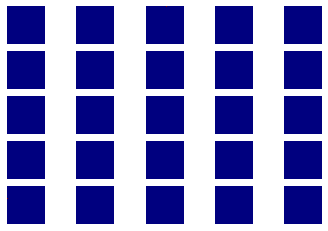

675 [D loss: 0.001897, acc.: 100.00%] [G loss: 5.818489]


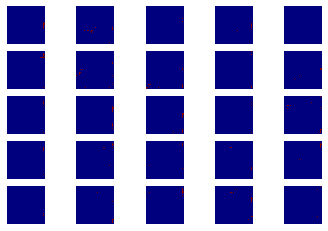

700 [D loss: 0.162696, acc.: 95.31%] [G loss: 2.125780]


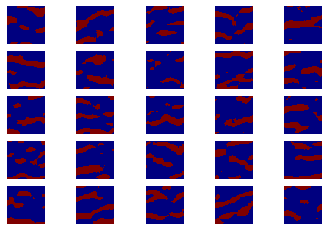

725 [D loss: 0.356605, acc.: 85.16%] [G loss: 1.333330]


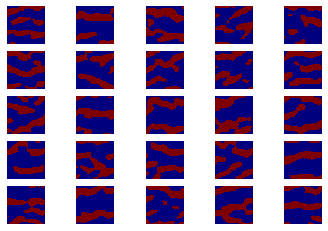

750 [D loss: 0.181490, acc.: 92.97%] [G loss: 0.929676]


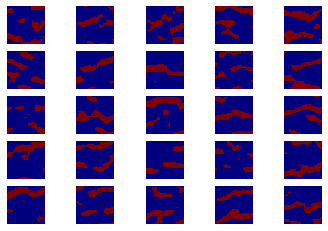

775 [D loss: 0.458976, acc.: 77.34%] [G loss: 2.546958]


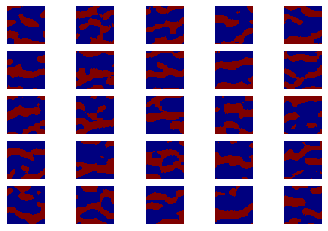

800 [D loss: 0.181359, acc.: 92.97%] [G loss: 1.332905]


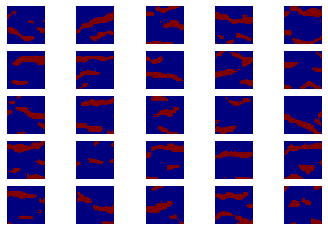

825 [D loss: 0.468189, acc.: 77.34%] [G loss: 2.318192]


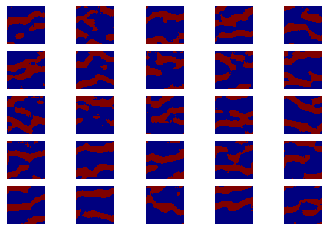

850 [D loss: 0.087108, acc.: 97.66%] [G loss: 0.890159]


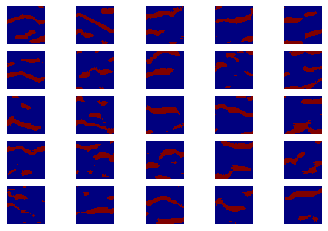

875 [D loss: 0.559201, acc.: 71.09%] [G loss: 1.551749]


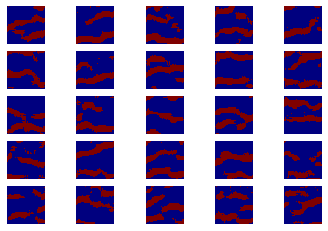

900 [D loss: 0.038017, acc.: 97.66%] [G loss: 0.069442]


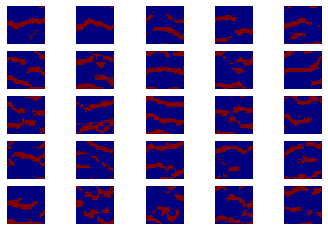

925 [D loss: 0.644028, acc.: 64.06%] [G loss: 2.067830]


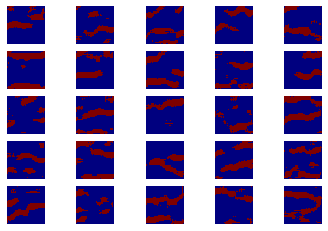

950 [D loss: 0.413466, acc.: 77.34%] [G loss: 1.025545]


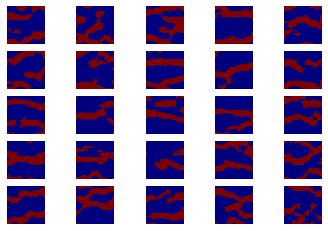

975 [D loss: 0.524634, acc.: 74.22%] [G loss: 2.373015]


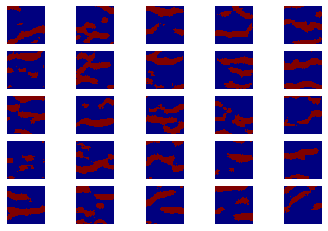

1000 [D loss: 0.410503, acc.: 78.91%] [G loss: 1.153483]


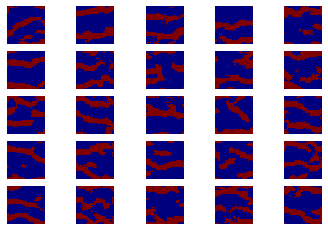

1025 [D loss: 0.424817, acc.: 78.12%] [G loss: 2.527471]


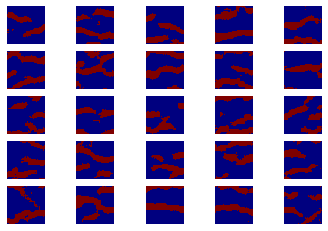

1050 [D loss: 1.010739, acc.: 49.22%] [G loss: 4.938645]


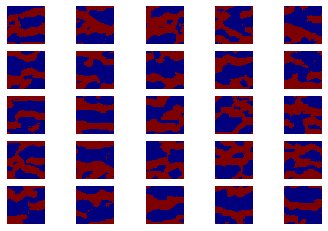

1075 [D loss: 0.401667, acc.: 81.25%] [G loss: 2.384456]


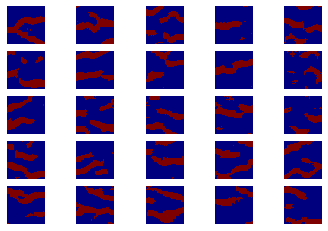

1100 [D loss: 0.390689, acc.: 83.59%] [G loss: 2.942517]


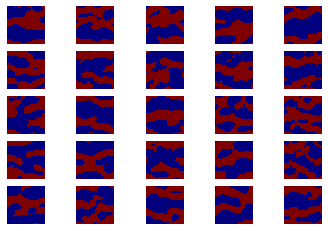

1125 [D loss: 0.408762, acc.: 82.81%] [G loss: 2.694350]


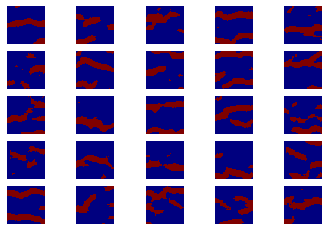

1150 [D loss: 0.727114, acc.: 62.50%] [G loss: 3.679330]


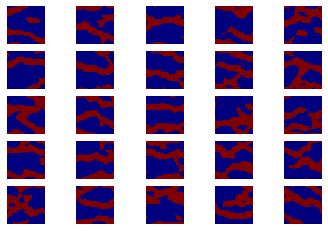

1175 [D loss: 0.321333, acc.: 82.81%] [G loss: 2.730442]


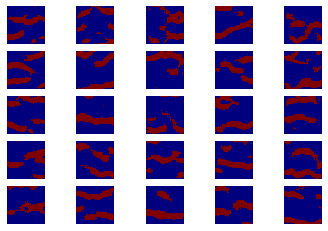

1200 [D loss: 0.277354, acc.: 89.84%] [G loss: 0.602970]


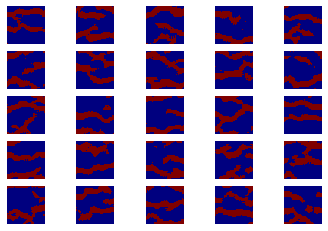

1225 [D loss: 0.457665, acc.: 79.69%] [G loss: 0.899600]


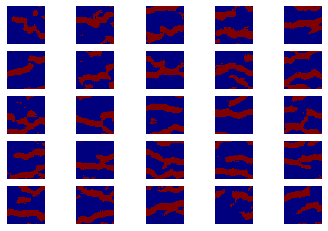

1250 [D loss: 0.155884, acc.: 95.31%] [G loss: 0.909796]


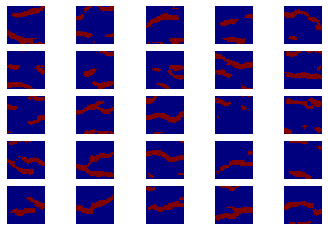

1275 [D loss: 0.179360, acc.: 95.31%] [G loss: 1.433897]


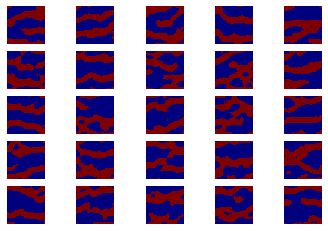

1300 [D loss: 0.282611, acc.: 85.94%] [G loss: 2.339639]


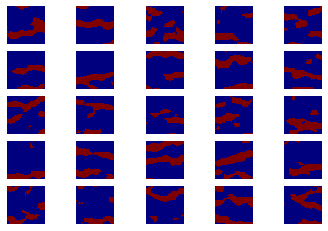

1325 [D loss: 0.315181, acc.: 89.84%] [G loss: 2.752381]


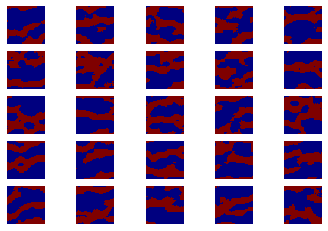

1350 [D loss: 0.520752, acc.: 70.31%] [G loss: 2.576318]


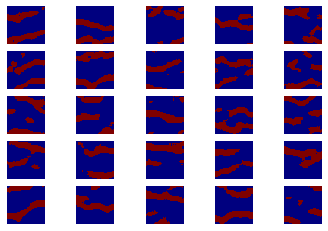

1375 [D loss: 0.215323, acc.: 93.75%] [G loss: 2.728078]


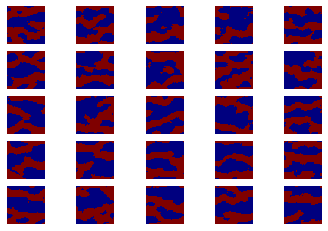

1400 [D loss: 0.427840, acc.: 77.34%] [G loss: 2.691937]


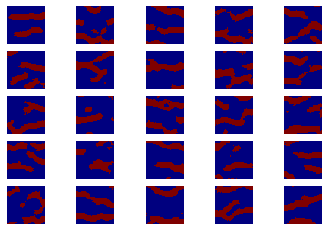

1425 [D loss: 0.369573, acc.: 82.81%] [G loss: 2.986489]


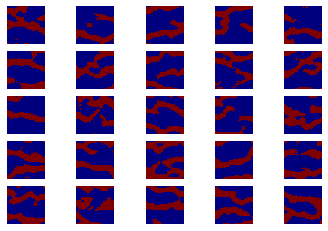

In [ ]:
iterations=3000
sample_interval=25

for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)

In [ ]:

noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)

# gen_imgs[gen_imgs>0]=1
# gen_imgs[gen_imgs<0]=0

r, c = 2, 8
figure, axs = plt.subplots(r, c,figsize=(c*2, r*2))
cnt = 0
for i in range(r):
    for j in range(c):
        a=axs[i,j].imshow(gen_imgs[cnt,:,:,0], aspect='equal', cmap = cm.jet, interpolation = 'none', clim = (0, 1))
        axs[i,j].axis('off')
        cnt += 1

plt.subplots_adjust(bottom=0.1, right=0.82, top=0.9)
cax = plt.axes([0.85, 0.1, 0.015, 0.8])
plt.colorbar(a,cax=cax)
plt.show()
plt.close()